# GLM for a single fMRI run

The first step in running a GLM (univariate) analysis is to model the activation of each voxel across a single fMRI run from a single participant. This is often called a first-level analysis. Let's load in the libraries we will use to do this.

In [3]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator
import warnings
warnings.filterwarnings('ignore') 

Next up we can define where our dataset is located and load in the BIDS file organization.

In [4]:
data_dir = '/Users/michael/Dropbox/work/data/dartbrains/data/localizer'
layout = BIDSLayout(data_dir,derivatives=True)

/opt/homebrew/Caskroom/miniforge/base/envs/pymri/lib/python3.10/site-packages/bids/layout/validation.py:156: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Load in the preprocessed data from one participant:

BOLD data info - TR: 2.4, volumes: 128, voxels: 238955


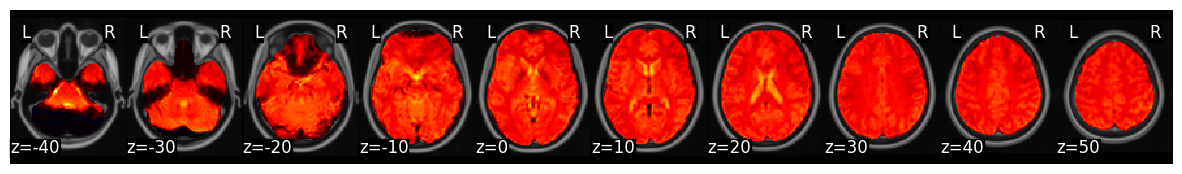

In [180]:
sbj = 'S04'
task = 'localizer'

bold_file = layout.get(subject=sbj,task=task,scope='derivatives',
                       suffix='bold',extension='nii.gz',return_type='file')
bold = Brain_Data(bold_file)
TR = layout.get_tr() # TR duration
n_TR = len(bold) # number of volumes (i.e., TRs) 
n_voxels = bold.data.shape[1]
print(f'BOLD data info - TR: {TR}, volumes: {n_TR}, voxels: {n_voxels}')
bold.mean().plot()

## Building a design matrix

To run a GLM, we need a design matrix that includes separate predictors for our experimental events and all the nuisance and noise covariates that can potentially impact BOLD measures. nltools provides a handy set of data structures (`Design_Matrix`) and functions (e.g., `onsets_to_dm()`) to buid a design matrix.

### Experiment events

We can read in the events file from the BIDS dataset using pandas, then leverage nltools' `onsets_to_dm` function to turn these events into a `Design_Matrix` instance. First, let's check out the events file.

In [181]:
events_file = layout.get(subject=sbj,scope='raw',task=task,suffix='events',return_type='file')[0]
events = pd.read_csv(events_file,sep='\t')
events.head(10)

,onset,duration,trial_type
0,0.0,1,video_computation
1,2.4,1,video_computation
2,8.7,1,horizontal_checkerboard
3,11.4,1,audio_right_hand
4,15.0,1,audio_sentence
5,18.0,1,video_right_hand
6,20.7,1,audio_sentence
7,23.7,1,audio_left_hand
8,26.7,1,video_left_hand
9,29.7,1,audio_sentence


`onsets_to_dm()` expects columns with specific names (i.e., Onset, Duration, and Stim). So, we have to relabel the columns in the events data structure before calling `onsets_to_dm()`. 

In [182]:
events.columns = ['Onset','Duration','Stim']
dm = onsets_to_dm(events,sampling_freq=1/TR,run_length=n_TR)
dm.info()
n_EV = dm.shape[1] # number of event predictors

<class 'nltools.data.design_matrix.Design_Matrix'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   video_computation        128 non-null    float64
 1   horizontal_checkerboard  128 non-null    float64
 2   audio_right_hand         128 non-null    float64
 3   audio_sentence           128 non-null    float64
 4   video_right_hand         128 non-null    float64
 5   audio_left_hand          128 non-null    float64
 6   video_left_hand          128 non-null    float64
 7   vertical_checkerboard    128 non-null    float64
 8   audio_computation        128 non-null    float64
 9   video_sentence           128 non-null    float64
dtypes: float64(10)
memory usage: 10.1 KB


The `Design_Matrix` data structure has several helpful methods and attributes. For example, `.info()` as shown above provides information about the different predictors. You can also view the design matrix with `.heatmap()`.

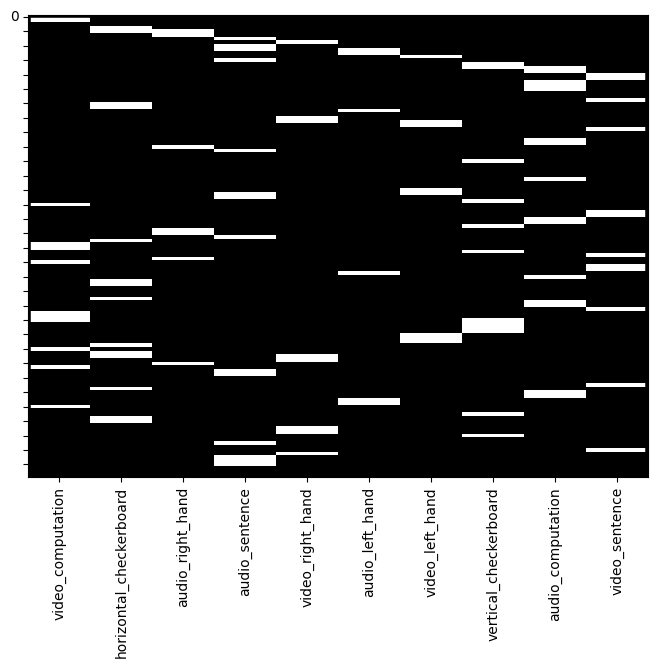

In [183]:
dm.heatmap()

### HRF Convolution

To better model the predicted BOLD response to the experimental events, we need to convolve our design matrix with a canonical hemodynamic response function (HRF). `Design_Matrix` has the `convolve()` method. By default is convolves all predictors with a double gamma HRF but alternatives can be used by setting specific parameters to the function. 

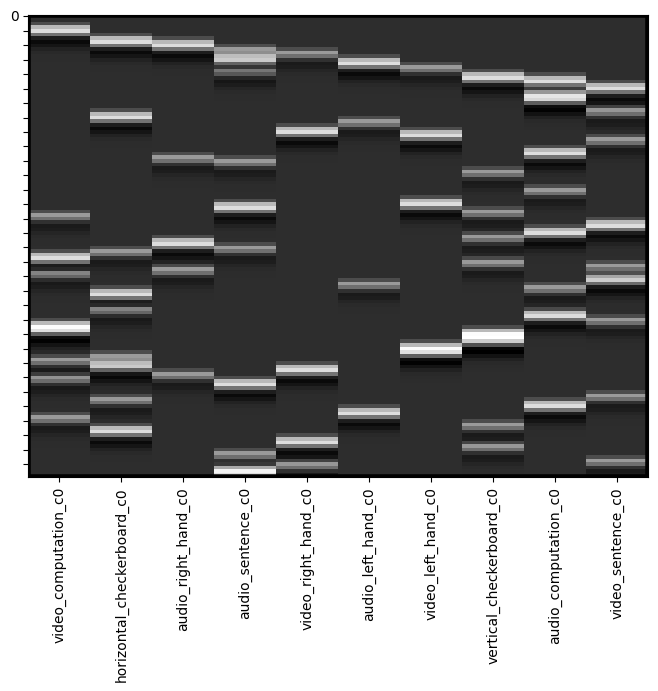

In [184]:
dm_conv = dm.convolve()
dm_conv.heatmap()

## Nuisance covariates

Don't forget about all those motion-related, high-pass filtering, and other nusiance covariates! 

### High-pass filtering

First up, high-pass filtering with DCT basis functions. nltools has a nice helper method to add these to any `DesignMatrix` instance:

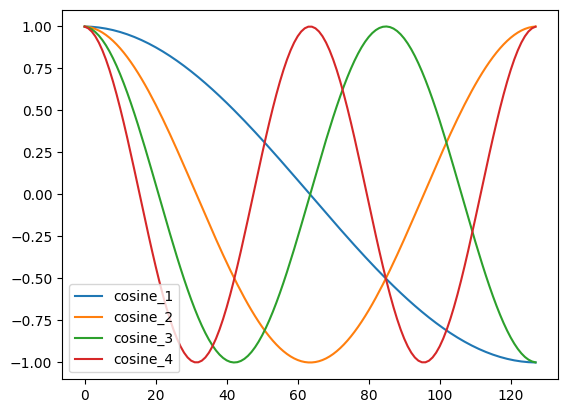

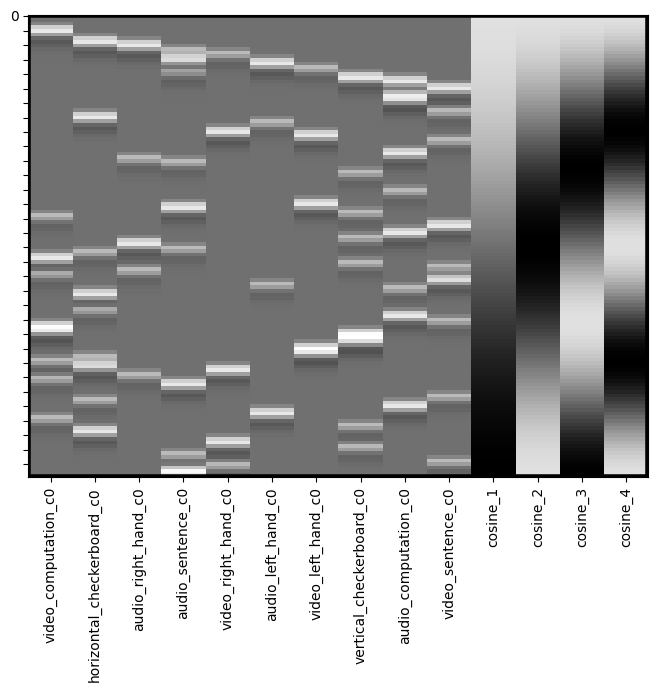

In [185]:
dm_conv_filt = dm_conv.add_dct_basis(duration=128)
dm_conv_filt.iloc[:,10:].plot()
dm_conv_filt.heatmap()

### Intercept and linear trends

Add in both an intercept and linear trend covariates with the `.add_poly()` method. The linear trends covariates remove slow drifts in the data that are common with fMRI. You can define polynomials with a specific order (1 = linear, 2 = quadratic) and setting `include_lower` to `True` will include all lower order covariates.

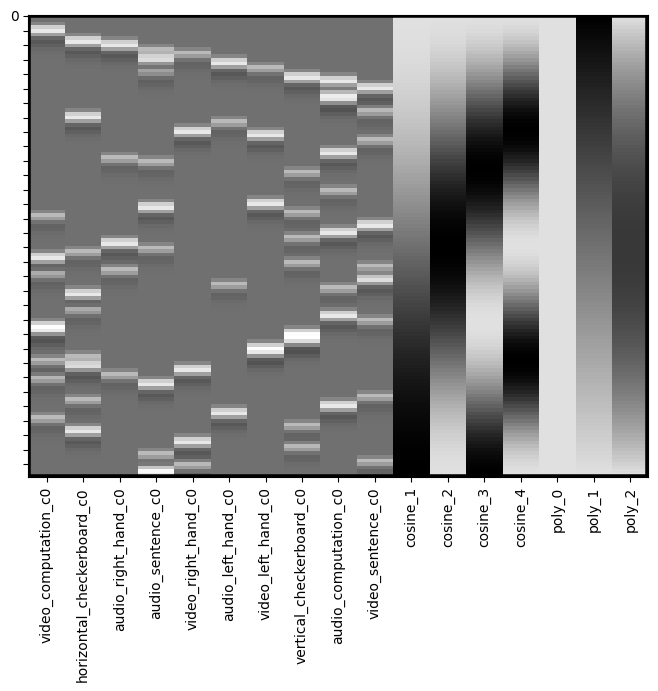

In [186]:
dm_conv_filt_poly = dm_conv_filt.add_poly(order=2,include_lower=True)
dm_conv_filt_poly.heatmap()

### Motion-related covariates

Head motion can introduce artifacts in BOLD measures. Although preprocessing typically includes motion correction such that BOLD timeseries are aligned across TRs, including covariates related to head motion is important in univariate modeling. If you are using fmriprep for preprocessing, these motion-related covariates are calculated and stored in a confounds file. Here's how to use it:

In [187]:
confound_file = layout.get(subject='S01',scope='derivatives',extension='.tsv',return_type='file')[0]
print(confound_file)
confounds = pd.read_csv(confound_file,sep='\t')
confounds.head()


/Users/michael/Dropbox/work/data/dartbrains/data/localizer/derivatives/fmriprep/sub-S01/func/sub-S01_task-localizer_desc-confounds_regressors.tsv


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,rot_x_derivative1_power2,rot_x_power2,rot_y,rot_y_derivative1,rot_y_derivative1_power2,rot_y_power2,rot_z,rot_z_derivative1,rot_z_derivative1_power2,rot_z_power2
0,5164.630182,NaN,NaN,2.667340e+07,4006.007667,NaN,1.604810e+07,NaN,3753.537871,NaN,...,NaN,4.016403e-07,0.000344,NaN,NaN,1.180596e-07,-0.000701,NaN,NaN,4.914346e-07
1,5178.481411,13.851229,191.856548,2.681667e+07,4011.819383,5.811716,1.609469e+07,33.776043,3760.408417,6.870546,...,8.622980e-09,2.925631e-07,0.000569,0.000225,5.063355e-08,3.233253e-07,-0.000776,-0.000075,5.666476e-09,6.026417e-07
2,5161.040643,-17.440768,304.180395,2.663634e+07,4006.766409,-5.052974,1.605418e+07,25.532548,3756.426086,-3.982332,...,6.975673e-08,6.480347e-07,0.000655,0.000086,7.409422e-09,4.286255e-07,-0.000524,0.000253,6.390582e-08,2.740564e-07
3,5150.604178,-10.436465,108.919794,2.652872e+07,4008.586021,1.819612,1.606876e+07,3.310987,3751.566090,-4.859996,...,1.673784e-07,1.567265e-07,0.000554,-0.000101,1.011674e-08,3.070412e-07,-0.000605,-0.000082,6.722360e-09,3.666230e-07
4,5172.441161,21.836983,476.853810,2.675415e+07,4007.189291,-1.396730,1.605757e+07,1.950854,3746.298200,-5.267890,...,2.102616e-08,2.925631e-07,0.000997,0.000443,1.959195e-07,9.934926e-07,-0.000840,-0.000235,5.510428e-08,7.059982e-07


As you can see above, the confounds file includes many different measures of potential confounds. Select the ones that you care about and create a `Design_Matrix` instance with them. Below, we are selecting global singal, framewise displacement, and 24 covariates related to motion. fmriprep also provides covariates for potential spikes (columns labeled as motion_outlier* in the confounds file), so we will include those too.

<AxesSubplot: >

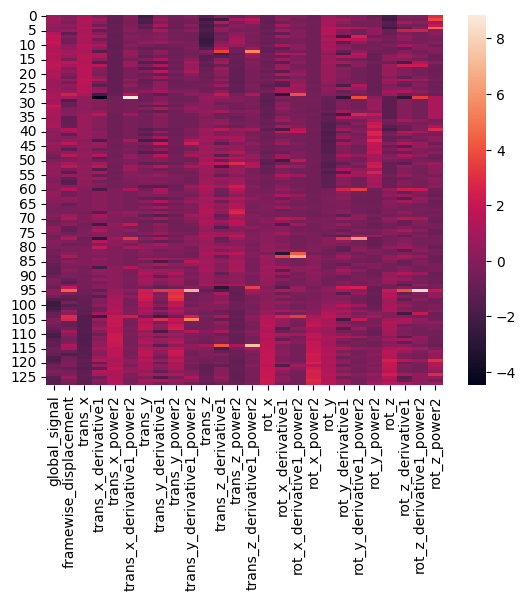

In [188]:
# covariate column names to include
inc = ['global_signal','framewise_displacement', \
       'trans_x','trans_x_derivative1','trans_x_power2','trans_x_derivative1_power2', \
       'trans_y','trans_y_derivative1','trans_y_power2','trans_y_derivative1_power2', \
       'trans_z','trans_z_derivative1','trans_z_power2','trans_z_derivative1_power2', \
       'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2', \
       'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2', \
       'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2']
mc = confounds[inc]
z_mc = zscore(mc)
z_mc.fillna(value=0,inplace=True) # NAs need to be replaced with 0s
# find any potential spike covariates
spikes = confounds.loc[:,confounds.columns.str.startswith('motion_outlier')]
# create the motion related design matrix
nuisance = Design_Matrix(pd.concat([z_mc,spikes],axis=1),sampling_freq=1/TR)

sns.heatmap(nuisance)

### Putting it all together

We can create our final design matrix that includes our events, high-pass filtering, polynomials, and motion-related covariates with a pandas `concat()` call becasue `Design_Matrix` is based on the pandas `DataFrame` structure. So, undernearth it all, anything you can do with a pandas `DataFrame` you can do with a `Design_Matrix`.

<AxesSubplot: >

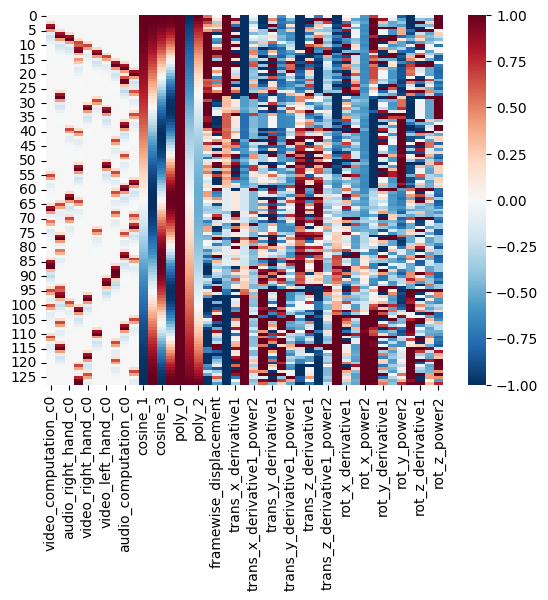

In [189]:
dm_conv_filt_poly_cov = pd.concat([dm_conv_filt_poly,nuisance],axis=1)
sns.heatmap(dm_conv_filt_poly_cov,cmap='RdBu_r',vmin=-1,vmax=1)

## Smoothing

With a finished design matrix, we can now return to the BOLD data. It is common to smooth data to increase signal-to-noise ratio (which helps with the assumptions of random field theory). Smoothing is a method attached to any `Brain_Data` instance and has a default 3D Gaussian smoothing kernel defined by the full width half maximum (FWHM).

In [190]:
fwhm = 6
smoothed = bold.smooth(fwhm=fwhm)

We can compare the original and smoothed data. Here's the original data:

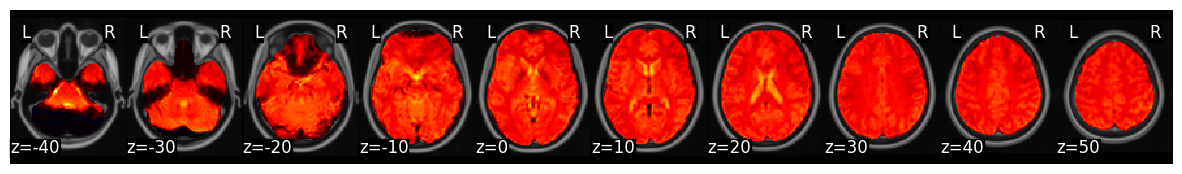

In [191]:
bold.mean().plot()

And the smoothed data:

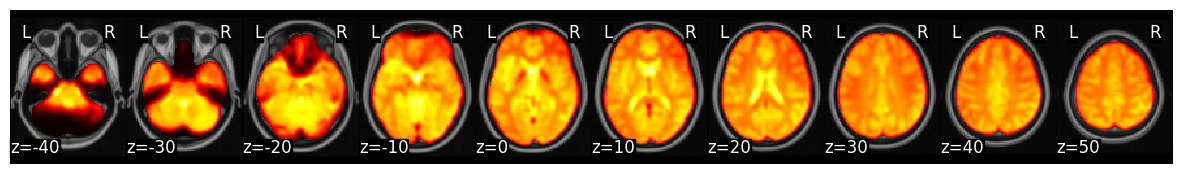

In [192]:
smoothed.mean().plot()

## Estimate GLM

We are finally ready to estimate the GLM for all voxels. To do so, we will assign the full design matrix to the `X` attribute of our smoothed data and run the `regress()` method.

In [193]:
smoothed.X = dm_conv_filt_poly_cov
stats = smoothed.regress()

# list of result measures from the regress() call
print(stats.keys())
# returns dictionary of Brain_Data instances
type(stats['beta'])

dict_keys(['beta', 't', 'p', 'df', 'sigma', 'residual'])


nltools.data.brain_data.Brain_Data

The result of the `.regress()` call is a dictionary of `Brain_Data` instances that contain different attributes of the GLM estimation for each of the predictors. This includes beta, t, and p maps and residuals.

In [194]:
print(smoothed.X.columns)
stats['beta'].iplot()

Index(['video_computation_c0', 'horizontal_checkerboard_c0',
       'audio_right_hand_c0', 'audio_sentence_c0', 'video_right_hand_c0',
       'audio_left_hand_c0', 'video_left_hand_c0', 'vertical_checkerboard_c0',
       'audio_computation_c0', 'video_sentence_c0', 'cosine_1', 'cosine_2',
       'cosine_3', 'cosine_4', 'poly_0', 'poly_1', 'poly_2', 'global_signal',
       'framewise_displacement', 'trans_x', 'trans_x_derivative1',
       'trans_x_power2', 'trans_x_derivative1_power2', 'trans_y',
       'trans_y_derivative1', 'trans_y_power2', 'trans_y_derivative1_power2',
       'trans_z', 'trans_z_derivative1', 'trans_z_power2',
       'trans_z_derivative1_power2', 'rot_x', 'rot_x_derivative1',
       'rot_x_derivative1_power2', 'rot_x_power2', 'rot_y',
       'rot_y_derivative1', 'rot_y_derivative1_power2', 'rot_y_power2',
       'rot_z', 'rot_z_derivative1', 'rot_z_derivative1_power2',
       'rot_z_power2'],
      dtype='object')


interactive(children=(FloatText(value=0.0, description='Threshold'), IntSlider(value=0, continuous_update=Fals…

## Contrasts



In [195]:
c1 = np.zeros(len(stats['beta']))
c1[smoothed.X.columns.str.startswith('video_')] = 1/4 # average together video predictors
c1[smoothed.X.columns.str.startswith('audio_')] = -1/4 # average together audio predictors
pd.DataFrame(np.array([smoothed.X.columns,c1]).T) # clunk way to show contrast weights

,0,1
0,video_computation_c0,0.25
1,horizontal_checkerboard_c0,0.0
2,audio_right_hand_c0,-0.25
3,audio_sentence_c0,-0.25
4,video_right_hand_c0,0.25
5,audio_left_hand_c0,-0.25
6,video_left_hand_c0,0.25
7,vertical_checkerboard_c0,0.0
8,audio_computation_c0,-0.25
9,video_sentence_c0,0.25


To perform the contrast, simply multiply it by the beta maps.

In [196]:
video_audio = stats['beta']*c1
video_audio.iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

## Save the results

Don't forget to save the results of the GLM! `Brain_Data` instances can be easily saved with the `.write()` method. Just provide a path to the output file name and the data will be saved to a compressed NiFTI file.

Note in the code below I am saving the GLM results in a way that at least feels BIDS compliant. I'm using the derivates directory and am preserving some of the important BIDS fields (e.g., sub, task) in the file names.

In [197]:
output_dir = os.path.join(data_dir,'derivatives','pyglm',f'sub-{sbj}')
print(output_dir)
os.makedirs(output_dir,exist_ok=True) # create directory if it doesn't exist

# save each experimental predictor
for x in range(n_EV):
    pred_prefix = os.path.join(output_dir,f'sub-{sbj}_task-{task}_glm-stim_{dm.columns[x]}')
    if x==0:
        print(pred_prefix)
    stats['beta'][x].write(f'{pred_prefix}_beta.nii.gz')
    stats['t'][x].write(f'{pred_prefix}_t.nii.gz')

# save the video-audio contrast
video_audio.write(os.path.join(output_dir,
                  f'sub-{sbj}_task-{task}_glm-stim_videoaudio_contrast.nii.gz'))

/Users/michael/Dropbox/work/data/dartbrains/data/localizer/derivatives/pyglm/sub-S04
/Users/michael/Dropbox/work/data/dartbrains/data/localizer/derivatives/pyglm/sub-S04/sub-S04_task-localizer_glm-stim_video_computation
